# Regression Analysis

    1. Use statsmodel as way to determine baseline R^2
    2. Cross validate data 
    3. Create graphs to enhance understanding of data 

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import operator

In [2]:
"""
Load data from Data scraping/clenaing script
"""

df_advanced_stats = pd.read_pickle('df_advanced_stats.pickle')
example_players = pd.read_pickle('example_players')

In [3]:
# creating test dataframe to run with statsmodels 
test_df = df_advanced_stats.groupby('Player').agg({'WS_first_2yr':'mean','Age_yr1':'mean','Career_length':'mean'})

# creating data frames to run cross validation with
data = df_advanced_stats.groupby('Player').agg({'WS_first_2yr':'mean','Age_yr1':'mean'})
target = df_advanced_stats.groupby('Player').agg({'Career_length':'mean'})


In [4]:
"""
Function that returns summary of linear regression for different dataframes
"""
def lin_reg(dataframe):
    y, X = patsy.dmatrices('Career_length ~ WS_first_2yr + Age_yr1',
                       data=dataframe, return_type="dataframe")

    model = sm.OLS(y, X)
    fit = model.fit()
    return fit.summary()

In [5]:
lin_reg(test_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Career_length   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     241.9
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           2.80e-81
Time:                        20:31:19   Log-Likelihood:                -1861.2
No. Observations:                 731   AIC:                             3728.
Df Residuals:                     728   BIC:                             3742.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.6365      1.283     10.630      0.000      11.118      16.155
WS_first_2yr     1.2248      0.059     20.796      0.000       1.109       1.340
Age_yr1         -0.4108      0.057     -7.255      0.000      -0.522      -0.300
==============================================================================
Omnibus:                       73.744   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.121
Skew:                           0.834   Prob(JB):                     3.65e-21
Kurtosis:                       3.558   Cond. No.                         255.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
"""
Breaking our dependent and indepent variables into testing and training groups
"""

X, y = data, target

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

X, y = np.array(X), np.array(y)


In [7]:
"""
Perfomring cross validation with 5 folds over our training data 
"""

kf = KFold(n_splits=5, shuffle=True, random_state = 56)
cv_lm_r2s = []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    

print('Simple regression scores: ', cv_lm_r2s)
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

Simple regression scores:  [0.4284286397163193, 0.49392969506167517, 0.28657837793590013, 0.4749487132928655, 0.32969176164087066]
Simple mean cv r^2: 0.403 +- 0.081


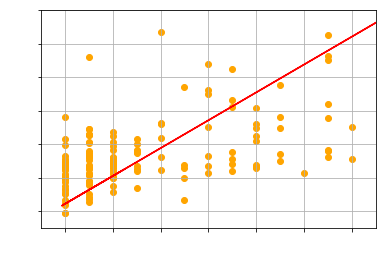

In [8]:
"""
Graphing predicted career length vs actual career length
All labels and axis turned white so it shows in presentation
"""

predictions = lm.predict(X_test)
# flattens predicitions
prediction_list = [item for sublist in predictions for item in sublist]

# defines m and b for best fit line 
m, b = np.polyfit(prediction_list, y_test, 1)

plt.scatter(y_test, predictions, color = 'orange')
plt.xlim(1, 15)
plt.ylim(1, 14)
plt.plot(prediction_list, m*prediction_list + b, color = 'red')

plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.xlabel('Actual Career Length', color = 'white')
plt.ylabel('Predicted Career Length', color = 'white')
plt.grid('white')

plt.savefig('Pred_vs_act', dpi = 300, transparent = True)

In [9]:
# Determine R^2 and RMSE respectively 
print(lm.score(X_test, y_test))
print(sqrt(mean_squared_error(y_test, predictions)))

0.2790710464389846
2.998251040755731


In [10]:
# Examining example players
minus_career_length = example_players.groupby('Player').agg({'WS_first_2yr':'mean','Age_yr1':'mean'})
prediction_example = lm.predict(minus_career_length)
print(prediction_example)
minus_career_length.head()

[[ 4.63221081]
 [ 6.28082842]
 [14.50169746]
 [18.3578713 ]
 [ 6.53454552]]


,WS_first_2yr,Age_yr1
Player,,
Brandon Hunter,0.4,23.0
Darko Miličić,-0.2,18.0
Dwyane Wade,7.8,22.0
LeBron James,9.7,19.0
Maciej Lampe,0.0,18.0


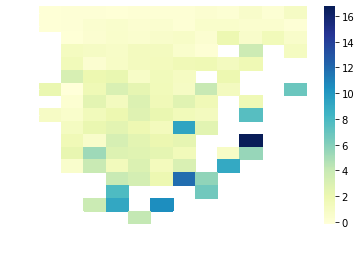

In [11]:
# Heatmap creation 
data = pd.DataFrame({'WS first 2 years': data.WS_first_2yr, 'Career_length': target.Career_length, 'Age entering NBA': data.Age_yr1})
data_pivoted = data.pivot_table("WS first 2 years", "Career_length", "Age entering NBA")
ax = sns.heatmap(data_pivoted, cmap="YlGnBu")
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

plt.savefig('Heatmap', dpi = 300, transparent = True)